In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from datasets import load_y2h_prs_rrs_data, load_GPCA_and_MAPPIT_data
from plotting import checkerboard, COLOR_PRS
from plotting import validation_plot, COLOR_PRS, COLOR_RRS


In [2]:
# the ipython matplotlib inline display overrides the rcParams
# that used to be called on the pyplot import but now seems like
# it's called on the first use of inline figures or something 
# problem is in ipython: https://github.com/ipython/ipython/issues/10383
# should be fixed soon: https://github.com/ipython/matplotlib-inline/pull/14
plt.show()
mpl.rcParams['font.size'] = 7.
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['savefig.dpi'] = 500

In [3]:
def make_checkerboard(data, experiments_to_plot, name, dataset='PRS', **kwargs):
    
    if dataset not in ('PRS', 'RRS'):
        raise ValueError('Must be PRS or RRS')
    
    if 'orientation' in data.columns:
        prs_data = (data.loc[data['source_dataset'] == 'sc' + dataset + 'v2', :]
                        .pivot(index='pair_gene_names',
                               columns='orientation',
                               values=['r02 v1', 'r02 v4', 'S07']))
        prs_data.columns = [c[1] + ' ' + c[0] for c in prs_data.columns]
        prs_data['gene_name_X'] = prs_data.index.map(lambda x: x.split(' ')[0]).values
        prs_data['gene_name_Y'] = prs_data.index.map(lambda x: x.split(' ')[1]).values
    else:
        prs_data = data.loc[data['source_dataset'] == 'sc' + dataset + 'v2', :].copy()
    n_rrs_pairs = data.loc[data['source_dataset'] == 'scRRSv2', 'pair_gene_names'].nunique()

    color_for_scores = {'Positive': COLOR_PRS, 
                        'Negative': 'white',
                         'Test failed': 'grey', 
                        'Autoactivator': 'teal', 
                        'Failed sequence confirmation': 'blue'
                   }

    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(18 * (prs_data.shape[0] / n_rrs_pairs), 0.4 + 0.05 * len(experiments_to_plot))
    pairs_order = checkerboard(prs_data, 
                               protein_a_column='gene_name_X', 
                               protein_b_column='gene_name_Y',
                               detection_columns=experiments_to_plot,
                               colors=color_for_scores,
                               draw_box=True,
                               draw_gene_names=True,
                               draw_grid=True,
                               grid_color='grey',
                               ax=ax,
                               **kwargs)
    ax.legend(handles=[Patch(facecolor=color, edgecolor='grey', label=label) 
                       for label, color in color_for_scores.items()
                       if label in set(prs_data[experiments_to_plot].values.flatten())],
              loc='center left', bbox_to_anchor=[1., 0.5])
    
    plt.savefig('../figures/{}_checkerboard_Y2H_{}.pdf'.format(dataset, name), bbox_inches='tight')
    return pairs_order


def one_score_per_pair(scores):
    """Collapse the scores for the two orientations to a single score"""
    #print(scores)
    #raise UserWarning()
    if len(scores) == 1:
        return scores.iloc[0]
    elif len(scores) > 2:
        raise UserWarning('Should only have two orientations')
        
    if (scores == 'Positive').any():
        return 'Positive'
    elif (scores == 'Negative').any() or (scores == 'Autoactivator').any():
        return 'Negative'
    else:
        return 'Test failed'


df = load_y2h_prs_rrs_data()
perpair = (df.groupby('pair_gene_names')
            .aggregate({'orf_name_X': lambda x: x.iloc[0],
                        'orf_name_Y': lambda x: x.iloc[0],
                        'gene_name_X': lambda x: x.iloc[0],
                        'gene_name_Y': lambda x: x.iloc[0],
                        'source_dataset': lambda x: x.iloc[0],
                        'S07': one_score_per_pair,
                        'r02 v1': one_score_per_pair,
                        'r02 v4': one_score_per_pair})
           .reset_index())

val = load_GPCA_and_MAPPIT_data(remove_homodimers=False)
mappit = val.loc[(val['experiment_ID'] == 'Sv03') &
                  val['source_dataset'].isin(['scPRS-v2', 'scRRS-v2']), :]
gpca = val.loc[(val['experiment_ID'] == 'Sv01') &
                  val['source_dataset'].isin(['scPRS-v2', 'scRRS-v2']), :]
perpair['pair'] = perpair[['orf_name_X', 'orf_name_Y']].min(axis=1) + '_' + perpair[['orf_name_X', 'orf_name_Y']].max(axis=1)
if mappit['pair'].duplicated().any():
    raise UserWarning('Unexpected duplicates')
if gpca['pair'].duplicated().any():
    raise UserWarning('Unexpected duplicates')
perpair['MAPPIT'] = perpair['pair'].map(mappit.set_index('pair')['result_at_0_RRS'])
perpair['MAPPIT'] = perpair['MAPPIT'].map({True: 'Positive', False: 'Negative', np.nan: 'Test failed'})
perpair['GPCA'] = perpair['pair'].map(gpca.set_index('pair')['result_at_0_RRS'])
perpair['GPCA'] = perpair['GPCA'].map({True: 'Positive', False: 'Negative', np.nan: 'Test failed'})

perpair = perpair.rename(columns={'r02 v1': 'Y2H v1', 'r02 v4': 'Y2H v4'})

assays = ['Y2H v1', 'Y2H v4', 'MAPPIT', 'GPCA']

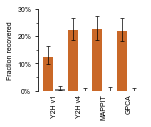

In [4]:
fig, ax = plt.subplots(ncols=1, nrows=1, sharey=True)
fig.set_size_inches(w=1.9, h=1.5)

pos = [((perpair['source_dataset'] == ds) & (perpair[assay_name] == 'Positive')).sum() for assay_name in assays for ds in ['scPRSv2', 'scRRSv2']]
ns = [((perpair['source_dataset'] == ds) & (perpair[assay_name] != 'Test failed')).sum() for assay_name in assays for ds in ['scPRSv2', 'scRRSv2']]
validation_plot(
    positives=pos,
    n_tested=ns,
    ax=ax,
    y_max=0.3,
    labels=['dummy'] * len(assays) * 2,
    draw_numbers=False,
    colors=[COLOR_PRS, COLOR_RRS] * len(assays),
    xlabel_rotation=90,
    errorbar_capsize=0.5,
    errorbar_thickness=0.7,
)
for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.xaxis.set_tick_params(length=0)
ax.set_facecolor('white')
ax.set_ylabel('Fraction recovered')
ax.set_yticklabels(['{:.0f}%'.format(y * 100) for y in ax.get_yticks()])
ax.set_xticks(np.linspace(0.5, 6.5, 4))
ax.set_xticklabels(assays)
fig.savefig('../figures/PRS_RRS_bar.pdf',
            bbox_inches='tight')

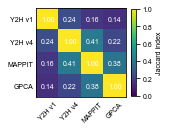

In [5]:
ji = np.zeros(shape=(len(assays), len(assays)))
for i, a in enumerate(assays):
    for j, b in enumerate(assays):
        res = perpair.loc[(perpair['source_dataset'] == 'scPRSv2')
                  & (perpair[a] != 'Test failed')
                  & (perpair[b] != 'Test failed'),
            [a, b]]
        ji[i, j] = ((res == 'Positive').all(axis=1).sum() / 
                      (res == 'Positive').any(axis=1).sum())
ji
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(2, 2)
cmap_name = 'viridis'
im = ax.imshow(ji, vmin=0, vmax=1, cmap=cmap_name)
for i in range(ji.shape[0]):
    for j in range(ji.shape[1]):
        ax.text(x=j, y=i, s=f"{ji[i, j]:.2f}", ha="center", va="center", color="white")
ax.set_xticks(range(len(assays)))
ax.set_xticklabels(assays)
ax.set_yticks(range(len(assays)))
ax.set_yticklabels(assays)
fig.colorbar(im, 
             label='Jaccard index', 
             shrink=0.8,
             ax=ax,
             location='right',
             )
ax.xaxis.set_tick_params(length=0, rotation=45)
ax.yaxis.set_tick_params(length=0)
fig.savefig(f'../figures/PRS_assays_Jaccard_heatmap_{cmap_name}.pdf',
            bbox_inches='tight')

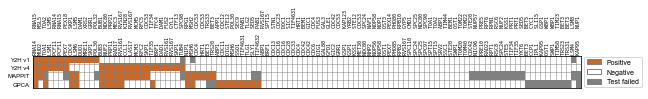

In [6]:
__ = make_checkerboard(perpair,
                       ['Y2H v1',
                        'Y2H v4',
                        'MAPPIT',
                        'GPCA'],
                        'v1-vs-v4-vs-MAPPIT-GPCA-collapsed_score_per_pair_with_failed',
                       'PRS',
                       alternative_sort=True)

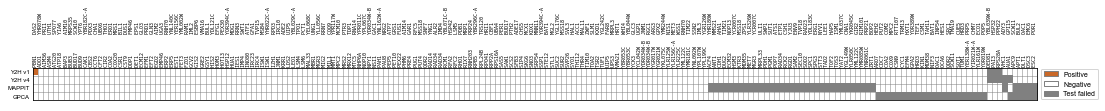

In [7]:
__ = make_checkerboard(perpair,
                       ['Y2H v1',
                        'Y2H v4',
                        'MAPPIT',
                        'GPCA'],
                        'v1-vs-v4-vs-MAPPIT-GPCA-collapsed_score_per_pair_with_failed',
                       'RRS',
                       )